**Student's name**

- Caspar Henking: 323825
- Vincent Roduit: 325140

This aim of this course is to review the evolution of image processing tools from hand-crafted methods to deep learning algorithms. The semester is split into four labs :

* **Lab 1** : Introduction to Image Processing Using Hand-Crafted Features
* **Lab 2** : Object detection
* **Lab 3** : Object tracking
* **Lab 4** : Introduction to Deep Learning for image classification and generative model

Let's start with the second chapter of this course!

# Chapter 2 : Object Detection and Recognition
(*100 points*)

In [1]:
# !pip install scikit-learn imageio

import cv2 as cv
import numpy as np
import os
import math
import tarfile
from utils import *
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

## 2.1 Template Matching
(*40 points*)

In this warm-up section, we will address the problem of detection and recognition using Template Matching. 

Template matching is a 'brute-force' algorithm for object recognition. The most basic method of template matching is to directly compare the grayscale images, without using edge detection. For example, if you were trying to detect, let's say a football, you will need to create a base template of the object. During the operation, the template matching algorithm would analyze the current image to find areas which are similar to the template. This basic approach is quite limited. For one thing, it is not robust to inconsistent changes in brightness within the image. If the template image has strong features, a feature-based approach may be considered; the approach may prove further useful if the match in the search image might be transformed in some fashion. For templates without strong features, or for when the bulk of the template image constitutes the matching image, a template-based approach may be effective. 

In the naive approach, the difference between the template and the matching area is computed pixel by pixel and used to calculate the overall error. It is possible to reduce the number of sampling points by reducing the resolution of the search and template images by the some factor and performing the operation on the resultant downsized images (multiresolution, or Pyramid (image processing)), providing a search window of data points within the search image so that the template does not have to search every viable data point or a combination of both.

![Template Matching Sample](../data/templateMatch.jpeg)

Template matching example. Left: Template image. Right: Input image with the resulting image highlighted.  

### 2.1.1 Objectives

In this section, we will explore the advantages and disadvantages of template matching method. However, in contrast with the previous Chapter, we will leave most of the implementation for the reader (i.e. you).

The following section will introduce to the most common metrics used for the matching distance and how to are used in OpenCV. Your task will be to: 
 * Implement each metric *by hand* 
 * Compare the accuracy against the OpenCV method 
 * Analyse and report your observations for each metric in 3 exercises and one mini-challenge.

As the final exercise, you will be given a set of more "challenging" data examples where using what you *learned before*, you will be asked to detect several objects in the scene. Your resulting algorithm __should have the given set of inputs and outputs__.

### 2.1.2 Distance, Minimums and Maximums

The two (and pretty much only) important parts of the Naive Template Matching algorithm is the *distance transform*, i.e. the metric to know if we found a match or not, and the global minima detection. 

For an  Input image $I$ of size $W\times H$, a template Image $T$ of size $w\times h$; ($w<W, h<H$), the distance methods implemented in OpenCv are the following: 

* Mean Squared Difference Method=CV_TM_SQDIFF

\begin{equation*}
R(x,y)= \sum _{x',y'} (T(x',y')-I(x+x',y+y'))^2 
\end{equation*}

* Normalized Mean Squared Difference Method=CV_TM_SQDIFF_NORMED
\begin{equation*}
        R(x,y)= \frac{\sum_{x',y'} (T(x',y')-I(x+x',y+y'))^2}{\sqrt{\sum_{x',y'}T(x',y')^2 \cdot \sum_{x',y'} I(x+x',y+y')^2}}
\end{equation*}

* Cross Correlation Method=CV_TM_CCORR
\begin{equation*}
        R(x,y)= \sum _{x',y'} (T(x',y') \cdot I(x+x',y+y'))
\end{equation*}

* Normalized Cross Correlation method=CV_TM_CCORR_NORMED
\begin{equation*}
        R(x,y)= \frac{\sum_{x',y'} (T(x',y') \cdot I(x+x',y+y'))}{\sqrt{\sum_{x',y'}T(x',y')^2 \cdot \sum_{x',y'} I(x+x',y+y')^2}}
\end{equation*}

* Correlation Coefficient Method=CV_TM_CCOEFF
\begin{equation*}
        R(x,y)= \sum _{x',y'} (T'(x',y') \cdot I'(x+x',y+y'))
\end{equation*}

where

\begin{equation*}
\begin{array}{l} T'(x',y')=T(x',y') - 1/(w \cdot h) \cdot \sum _{x'',y''} T(x'',y'') \\ I'(x+x',y+y')=I(x+x',y+y') - 1/(w \cdot h) \cdot \sum _{x'',y''} I(x+x'',y+y'') 
\end{array}
\end{equation*}

* Normalized Correlation Coefficient=CV_TM_CCOEFF_NORMED
\begin{equation*}
        R(x,y)= \frac{ \sum_{x',y'} (T'(x',y') \cdot I'(x+x',y+y')) }{ \sqrt{\sum_{x',y'}T'(x',y')^2 \cdot \sum_{x',y'} I'(x+x',y+y')^2} }
\end{equation*}


Please notice that the dimensions of the output image, $R$, will depend on how you handle the edges. The easiest way is to ser the return an output image of size $(W-w+1, H-h+1)$.

After the function finishes the comparison, the resulting image will contain an image map with the obtained values. In OpenCV, the best matches can be found as global minimums or maximums (depending which matric you used) using the `minMaxLoc()` function. 

**QUESTION** (/3)

For each function listed above, indicate if the best matching position is located either in the local minimums or in the maximums. 


**YOUR ANSWER**

- **Mean Squared Difference Method** : The best matching position is given by the local minima, as the smallest difference between the template and the input image gives the best template.


- **Normalized Mean Squared Difference Method** : Same as **Mean Squared Difference Method**. This is a normalized version of it.

- **Cross Correlation Method** : Here, the best matching position is given by the maxima, as an overlap in values of $(T(x',y')$ and $I(x+x',y+y'))$ will increase the cross correlation.

- **Normalized Cross Correlation method** : Same as **Cross Correlation Method**. This is a normalized version of it.

- **Correlation Coefficient Method** : This method is another version of the **Cross Correlation Method**. The mean is subtracted from I and T, solving the problem of bright pixels. The best matching position is then given by the maximum.

- **Normalized Correlation Coefficient** : Same as **Correlation Coefficient Method**. This is a normalized version of it.

**QUESTION** (/3)

Based on the template  `my_distance_fn()` in the next, implement the functions `sqdiff()`, `sqdiff_normed()`, `ccorr()`, `ccorr_normed()`, `ccoeff()` and `ccoeff_normed()` that takes as input a region of an image, and the template and returns the corresponding distance.

In [2]:
def my_distance_fn(image_patch, template):
    """
    Calculate the distance between image_patch and template
    :image_patch:       Input region of interest of the image.
    :template:          The Template Image.
    :return:            The dummy distance.
    """
    dummy_distance = np.sum(image_patch.astype(np.float32) - template.astype(np.float32))
    return  dummy_distance


#######################
# YOUR CODE HERE

def T1(template):

    return template - np.sum(template.astype(np.float32)) / (template.shape[0] * template.shape[1])

def I1(image_patch):

    return image_patch - np.sum(image_patch.astype(np.float32)) / (image_patch.shape[0] * image_patch.shape[1])

def sqdiff(image_patch, template): 

    return np.sum(np.square(template.astype(np.float32)) - image_patch.astype(np.float32))

def sqdiff_normed(image_patch, template):
    num = sqdiff(image_patch, template)

    den = np.sum(np.square(image_patch.astype(np.float32)))*np.sum(np.square(template.astype(np.float32))) + 1e-6
    return np.clip(num / np.sqrt(den), 0, 1)

def ccorr(image_patch, template):
    
    return np.sum(image_patch.astype(np.float32) * template.astype(np.float32))

def ccorr_normed(image_patch, template):
    num = ccorr(image_patch, template)
    den = np.sum(np.square(image_patch.astype(np.float32)))*np.sum(np.square(template.astype(np.float32))) + 1e-6
    return np.clip(num / np.sqrt(den), 0, 1)    

def ccoeff(image_patch, template):

    return np.sum(T1(template) * I1(image_patch))

def ccoeff_normed(image_patch, template):

    T_1, I_1 = T1(template), I1(image_patch)
    num = np.sum(T_1 * I_1)
    den = np.sum(np.square(T_1))*np.sum(np.square(I_1)) + 1e-6
    return np.clip(num / np.sqrt(den), 0, 1)
######################

The distance functions returns a single value, but we would like the distance between the image and the template at each pixel of the image. To do that, we use a sliding window approach which consists in selecting a region of interest in the image, calculate the distance between this region of interest and the template, and move to the next region of interest. In our case, the regions of interest are all regions of the same size of the template. We start at the pixel (0, 0) and move one pixel by one pixel.

**QUESTION** (/3)

In the next cell, implement the function `template_matching_process()` that takes as input an image, the template, and the distance function and returns the corresponding distance map between the image and the template.

In [3]:
def template_matching_process(image, template, dist_fn):
    """
    Given an input image, iterates over the image and computes the distance w/r
    the template, using a given distance function. 

    :input_image:       Input image. :) 
    :template:          The Template Image.
    :distance_function  Function used to compute the distance. The function should receive a image patch 
                        and a template as inputs.
    :return:            The distance map.
    """
    
    dist_map = None 
    #######################
    # YOUR CODE HERE

    img_h, img_w = image.shape
    temp_h, temp_w = template.shape
    dist_map = np.zeros((img_h - temp_h + 1, img_w - temp_w + 1))
    # img_patch_vec = np.array([image_patch for image_patch in image])
    for i in np.arange(dist_map.shape[0]) :
        for j in np.arange(dist_map.shape[1]) :

            img_roi = image[i:i+temp_h, j:j+temp_w]
            dist_map[i,j] = dist_fn(img_roi, template)
    
    # YOUR CODE HERE 
    
    return dist_map

The next cell tests your implementation with the distance function `sqdiff_normed()`.

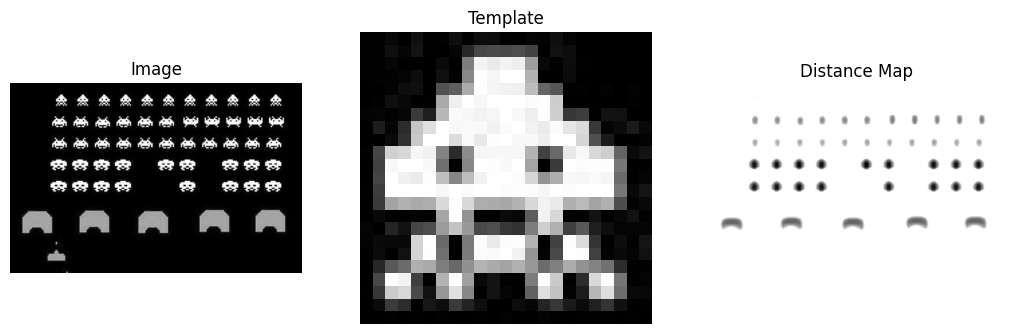

In [4]:
# load image
img_gray = cv.imread('../data/space-invaders_1.jpg', 0)
template = cv.imread('../data/template_0.png', 0)

# calculate distance
dist_map = template_matching_process(img_gray, template, sqdiff_normed)

# display
plt.figure(figsize=(12.8, 8.2))
plt.subplot(131)
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.title('Image')

plt.subplot(132)
plt.imshow(template, cmap='gray')
plt.axis('off')
plt.title('Template')

plt.subplot(133)
plt.imshow(dist_map, cmap='gray')
plt.axis('off')
plt.title('Distance Map')

plt.show()

**QUESTION**  (/3)

Check your outputs by using the build-in functions in OpenCV to compute the maps for each of the methods implemented. Show in each cell: your map and the OpenCV map.

Text(0.5, 1.0, 'OpenCv Distance Map')

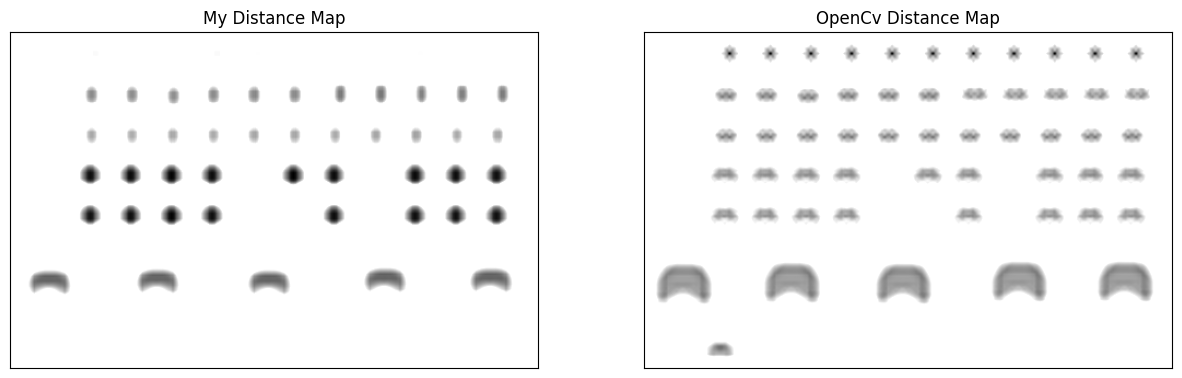

In [5]:
# Example
res = cv.matchTemplate(img_gray, template, cv.TM_SQDIFF_NORMED)

# Display two example maps
fig, ax = plt.subplots(1, 2, figsize=(15, 7),squeeze=False)
display_image(dist_map, axes=ax[0][0])
ax[0][0].set_title("My Distance Map")
display_image(res, axes=ax[0][1])
ax[0][1].set_title("OpenCv Distance Map")

Time needed for homemade function : 0.4264688491821289
Time needed for OpenCV function : 0.0029571056365966797


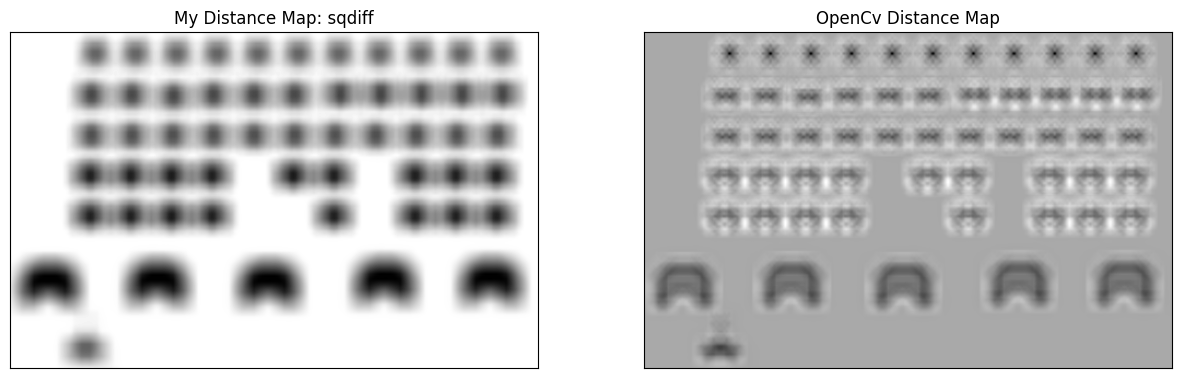

In [6]:
import time

def compare_method(image, template, method, method_cv):
    """
    Compare the results of the template matching using a given method with the OpenCV implementation.
    :image:     Input image.
    :template:  The Template Image.
    :method:    The method used to compute the distance.
    :return:    The distance map.
    """
    start = time.time()
    dist_map = template_matching_process(image, template, method)
    start_cv = time.time()
    res = cv.matchTemplate(image, template, method_cv)
    end = time.time()

    print('Time needed for homemade function :', start_cv - start)
    print('Time needed for OpenCV function :', end - start_cv)

    fig, ax = plt.subplots(1, 2, figsize=(15, 7),squeeze=False)
    display_image(dist_map, axes=ax[0][0])
    ax[0][0].set_title(f"My Distance Map: {method.__name__}")
    display_image(res, axes=ax[0][1])
    ax[0][1].set_title("OpenCv Distance Map")
    plt.show()

# sqdiff()
# YOUR CODE HERE
compare_method(img_gray, template, sqdiff, cv.TM_SQDIFF)


Time needed for homemade function : 1.9462487697601318
Time needed for OpenCV function : 0.0030989646911621094


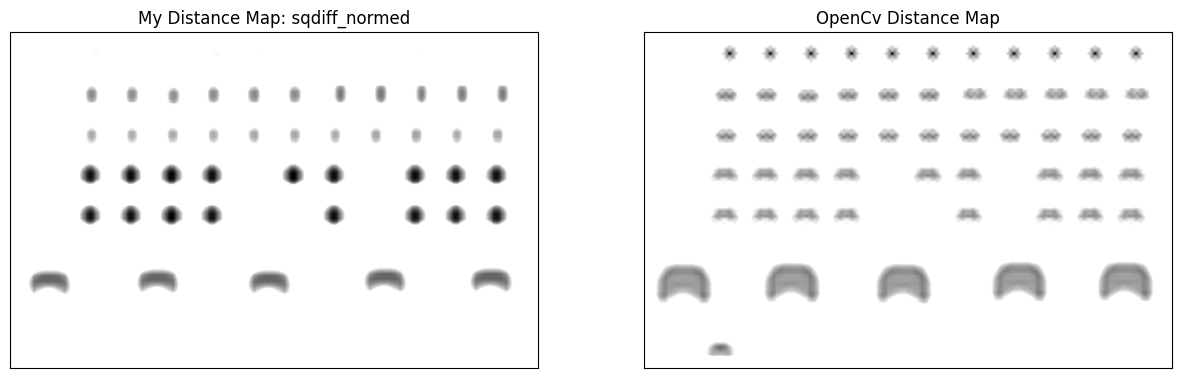

In [7]:
#sqdiff_normed()
# YOUR CODE HERE
compare_method(img_gray, template, sqdiff_normed, cv.TM_SQDIFF_NORMED)

Time needed for homemade function : 0.3935887813568115
Time needed for OpenCV function : 0.0030362606048583984


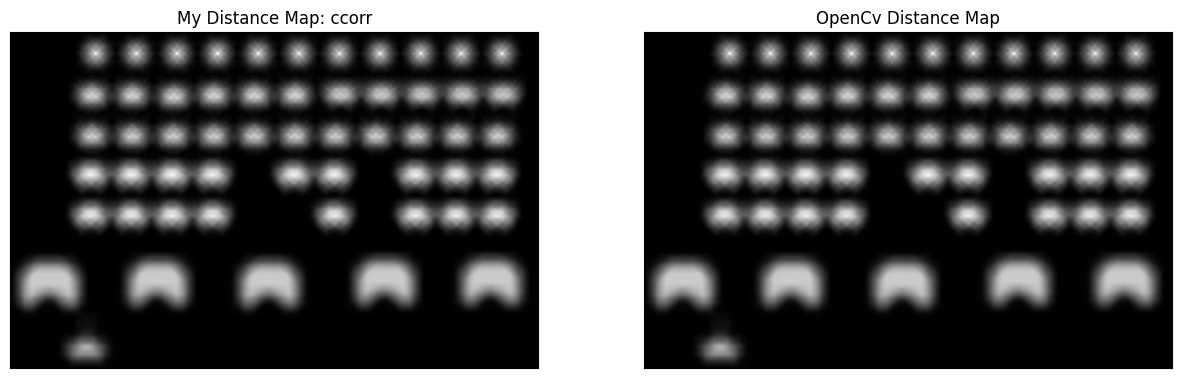

In [8]:
#ccorr()
# YOUR CODE HERE
compare_method(img_gray, template, ccorr, cv.TM_CCORR)

Time needed for homemade function : 1.9640648365020752
Time needed for OpenCV function : 0.003058910369873047


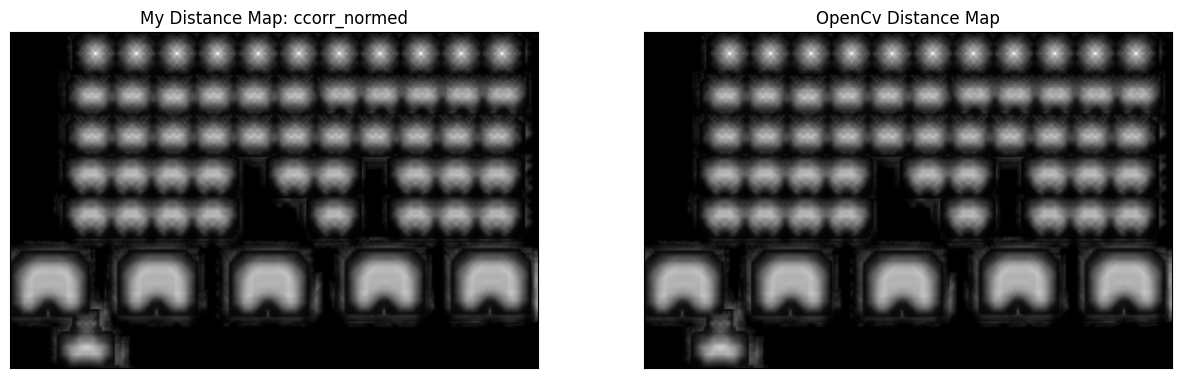

In [9]:
#ccorr_normed()
# YOUR CODE HERE
compare_method(img_gray, template, ccorr_normed, cv.TM_CCORR_NORMED)

Time needed for homemade function : 1.4406781196594238
Time needed for OpenCV function : 0.002908945083618164


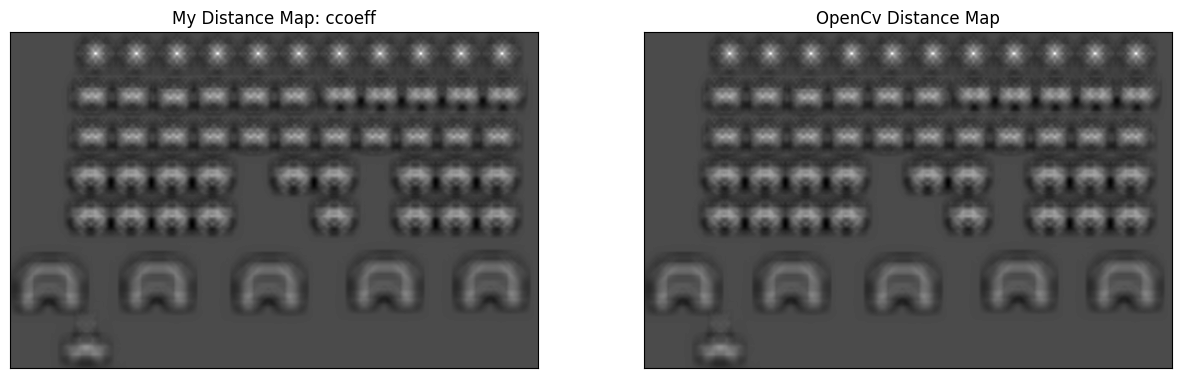

In [10]:
#ccoeff()
# YOUR CODE HERE
compare_method(img_gray, template, ccoeff, cv.TM_CCOEFF)

Time needed for homemade function : 2.710381031036377
Time needed for OpenCV function : 0.0032498836517333984


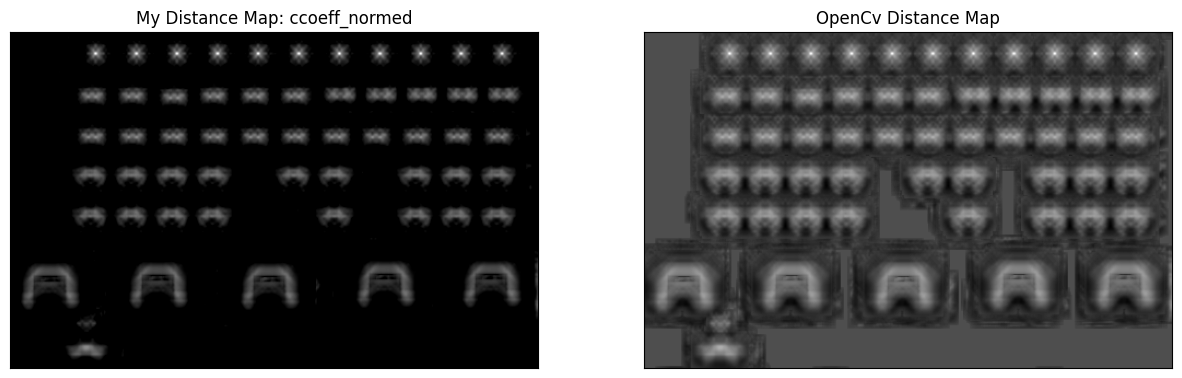

In [11]:
#ccoeff_normed()
# YOUR CODE HERE
compare_method(img_gray, template, ccoeff_normed, cv.TM_CCOEFF_NORMED)

**QUESTION** (/2)

Comment the differences between the OpenCV function and yours (speed, precision, etc).


**Answer**

Both methods seem to give the same results. However, OpenCV is a library using mainly C++ code, which is much faster than our Python code, therefore our homemade functions are slower.

### 2.1.3 Finding Local Minimums / Maximums

As explained before, in order to find the location of our possible object we need to find the minimum or maximum point in our resulting distance map. The  OpenCV function `cv.minMaxLoc()` can be used to find the local minimum and maximum of the single-channel array (1D or 2D) [[doc](https://docs.opencv.org/4.0.0/d2/de8/group__core__array.html#gab473bf2eb6d14ff97e89b355dac20707)]. 

However, if we want to detect several objects in the image, the function `cv.minMaxLoc()` won't give you all the locations. 

**QUESTION**  (/2)

Implement your own function, `multiMinMax()`, which takes an input 2D image `src` and returns an `output_array` with the locations of the minimums or maximums depending on the provided `flag` (`flag = "min"` or `flag = "max"`), and a given `params`. The `params` variable determines the number of matching objects to return. It can be, for example, a _threshold_ for the local minima/maxima, the maximum number of maximums/minimums to return, a difference between the global maxima/minima to be included, etc.

In [12]:
def multiMinMax(src, flag, params):
    """
    Return the extrema of an image
    :src:       Image
    :flag:      Minima or maxima
    :param:  Parameters of your function
    return: The minimum and maximum
    """
    
    #######################

    ## YOUR CODE HERE
    # Could be possible to add a condition depending on type of input

    # Flag conditioning
    if flag == 'min' :
        ret = np.where(src <= np.max(src)*params, True, False).nonzero()
    if flag == 'max' :
        ret = np.where(src >= np.max(src)*params, True, False).nonzero()

    #######################
    return ret

The next cell tests your implementation and draws the results.


There are 11 ROIs


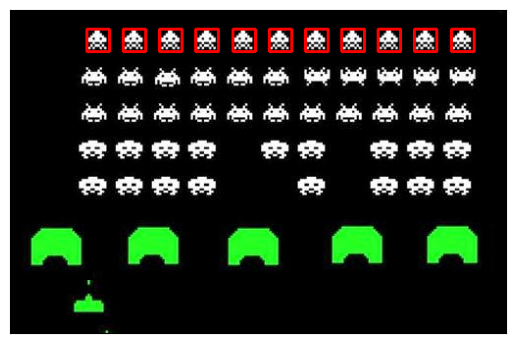

In [13]:
def drawROIS(src, template, locations, color = (0,0,255)):
    w, h = template.shape[::-1]
    # Make copy of image to draw on it without changing the original image
    canvas = src.copy();
    
    # Draw all rectangles
    for pt in zip(*locations[::-1]):
        cv.rectangle(canvas, pt, (pt[0] + w, pt[1] + h), color, 2)
    
    return canvas

# How should be called:
img_rgb  = cv.imread('../data/space-invaders_1.jpg')
img_gray = cv.imread('../data/space-invaders_1.jpg',0)
template = cv.imread('../data/template_0.png',0)

# For a given distance Map
distance_map_norm_corr = cv.matchTemplate(img_gray,template,cv.TM_CCORR_NORMED)
# Use your function here!
locations = multiMinMax(distance_map_norm_corr,'max',0.96)
# Draw the ROIs 
img_rgb_holder = drawROIS(img_rgb, template, locations)
# example:
display_image(img_rgb_holder)
# How many ROIS did you returned? 
print(f"There are {np.array(locations).shape[1]} ROIs")



Now that you are all set up, use the functions you implemented and *try* to detect ALL the matching objects in the input image (Using template Matching).

Rules:

* You can use any metric you want, self-implemented or from OpenCV. 
* You can tweak your `multiMinMax()` to get better results.
* For the points 1),2) and 3) below you have to do it in grayscale.
* 4) can use multi-channel heuristics.


#### 1) Perfect match <3

The next cell load the image and the templates. 


[]

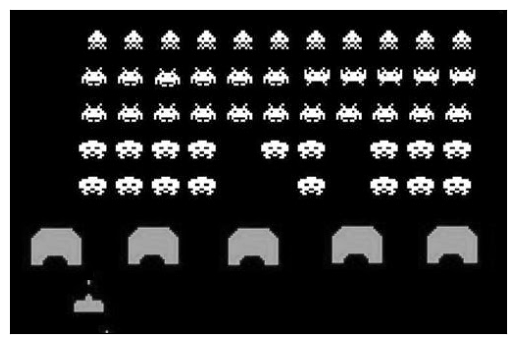

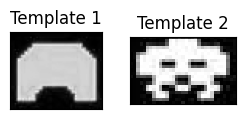

In [14]:
# input images to use
p1_src_rgb    = cv.imread('../data/space-invaders_1.jpg')
p1_src_gray   = cv.imread('../data/space-invaders_1.jpg',0)

# Show the matching of these 2 templates:
p1_template_1 = cv.imread('../data/template_1.png',0)
p1_template_2 = cv.imread('../data/template_2.png',0)

# Image
display_image(p1_src_gray)
fig, ax = plt.subplots(1, 2, figsize=(3, 1),squeeze=False)

# Templates
display_image(p1_template_1, axes=ax[0][0])
ax[0][0].set_title("Template 1")
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

display_image(p1_template_2, axes=ax[0][1])
ax[0][1].set_title("Template 2")
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

**QUESTION** (/4)

Using the graycale template `p1_template_1` and `p1_template_2` provided in the previous cell, detect all the objects in the image `p1_src_gray` and show the locations of the matching objects in the image `p1_src_rgb`.

Follow the code below and provide some insights like:

* Why did you choose that given metric?  
* How robust to false positives/negatives is your selected metric.
* Is the number of output locations the same as the matching objects? 



 There are 5 bridges detected
 There are 19 invaders detected


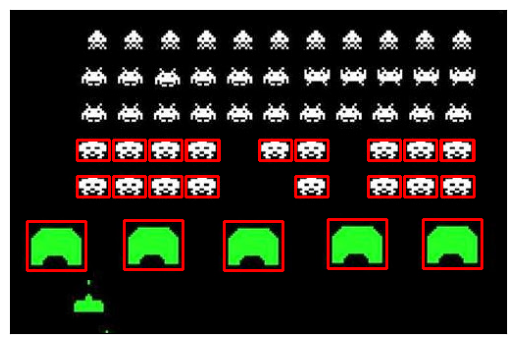

In [15]:
## YOUR CODE HERE
# Aucune inspiration

distance_map_t1 = cv.matchTemplate(p1_src_gray,p1_template_1,cv.TM_CCORR_NORMED)

locations_t1 = multiMinMax(distance_map_t1,'max',0.99)
print(f" There are {np.array(locations_t1).shape[1]} bridges detected")
distance_map_t2 = cv.matchTemplate(p1_src_gray,p1_template_2,cv.TM_CCORR_NORMED)

locations_t2 = multiMinMax(distance_map_t2,'max',0.977)
print(f" There are {np.array(locations_t2).shape[1]} invaders detected")

# Draw the ROIs 
src_holder_1 = drawROIS(p1_src_rgb,p1_template_1, locations_t1)

src_holder_2 = drawROIS(src_holder_1,p1_template_2, locations_t2)
# example:
display_image(src_holder_2)

**YOUR ANSWER**

- For perfect matches between templates and the content in the image, cross-correlation works pretty well. 
- Cross-correlation is not the best-performing metric when the image and template do not match perfectly, as small differences caused by noise can change drastically its value. Furthermore, if there is a slight disturbance either in the template or the image, our system is doomed as the threshold is very high.
- Moreover, we can see that there are 19 invaders detected which is more that the true number (17). This happens if a match occurs two times for the same object.
- Yes, it is the same.

#### 2) Not so perfect Match </3


The next cell load the image and the templates. 


[]

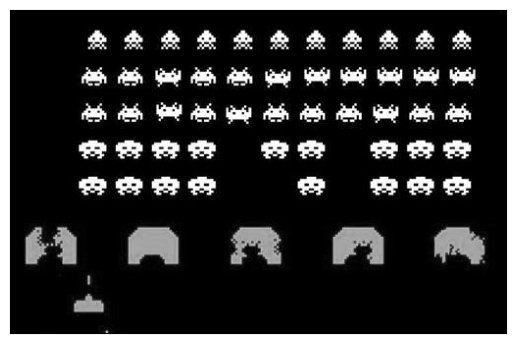

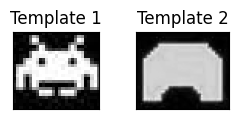

In [16]:
# input
p2_src_rgb    = cv.imread('../data/space-invaders_2.jpg')
p2_src_gray   = cv.imread('../data/space-invaders_2.jpg',0)

# 2 tempaltes (check that tempalte one don't match all the invaders in the same row) 
p2_template_1 = cv.imread('../data/template_3.png',0)
p2_template_2 = cv.imread('../data/template_1.png',0)

# Image
display_image(p2_src_gray)

# Templates
fig, ax = plt.subplots(1, 2, figsize=(3, 1),squeeze=False)
display_image(p2_template_1, axes=ax[0][0])
ax[0][0].set_title("Template 1")
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

display_image(p2_template_2, axes=ax[0][1])
ax[0][1].set_title("Template 2")
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

**QUESTION** (/4)

Using the graycale template `p2_template_1` and `p2_template_2` provided in the previous cell, detect all the objects in the image `p2_src_gray` and show the locations of the matching objects in the image `p2_src_rgb`. All the _invaders_ in the same row counts as the "same" class. 

Follow the code bellow and provide some insights like:

* How did you select the number of maximums/minimus?  
* How robust to false positives/negatives is your selected metric.
* Is the number of output locations the same as the matching objects? 
* Could you use any of the features from the last chapter to improve the matching?

 There are 103 bridges detected
 There are 133 invaders detected


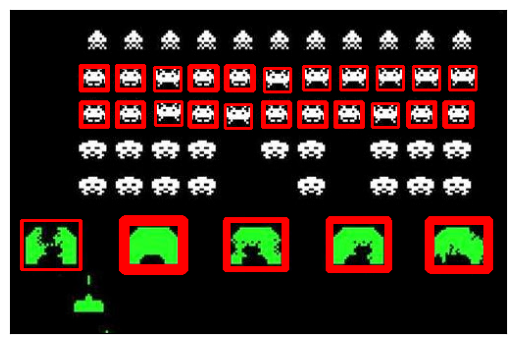

In [17]:
## YOUR CODE HERE

# Autant à la zeub que la cell précédente..? J'ai testé avec un autre metric

distance_map_t1 = cv.matchTemplate(p2_src_gray,p2_template_1,cv.TM_CCOEFF_NORMED)

locations_t1 = multiMinMax(distance_map_t1,'max',0.69)
print(f" There are {np.array(locations_t1).shape[1]} bridges detected")

distance_map_t2 = cv.matchTemplate(p2_src_gray,p2_template_2,cv.TM_CCOEFF_NORMED)

locations_t2 = multiMinMax(distance_map_t2,'max',0.75)
print(f" There are {np.array(locations_t2).shape[1]} invaders detected")

# Draw the ROIs 
src_holder_1 = drawROIS(p2_src_rgb,p2_template_1, locations_t1)

src_holder_2 = drawROIS(src_holder_1,p2_template_2, locations_t2)
# example:
display_image(src_holder_2)

**YOUR ANSWER**

- The minima and maxima were chosen such that all targets were selected through the process.
- This coefficient seems much more robust to FP-FN errors, as the threshold is lower but it still manages to find all the templates.
- The cost of applying a lower threshold is that there are much more objects detected as the reality (in fact 103 bridges and 133 invaders, instead of 5 and 17). But this can be easily handle with post processing (since they appears at the same location)
-  Edge detection can maybe be applied to improve the results. 

#### 3) Hidden objects game


Finding hidden objects in cluttered illustration is a popular casual game which develop your observation skills. In this exercise, you will use your template matching skills to develop an efficient object detector for this game.


We will play on scenes from the **Big Home Hidden Objects** game, in which image templates of the objects to find are shown at the bottom of the scene. We provide you the method `extract_big_home_templates()` to extract the grayscale template of each object given a scene.

The next cell load the image and the templates. 

In [18]:
# DO NOT MODIFY THIS FUNCTION
def extract_big_home_templates(image):
    
    # We extract list of objects in a heuristic manner
    list_image = image[370:418, 77:712].copy()
    
    # There are 10 objects per image
    n_objects = 10
    stride = list_image.shape[1]/10
    
    # Extract each template image
    objects = []
    for i in range(n_objects):
        object_rgb = list_image[:,int(stride*i):int(stride*(i+1))][15:-15,15:-15]
        center_coordinates = (int(object_rgb.shape[1]/2), int(object_rgb.shape[0]/2))
        object_rgb = cv2.ellipse(object_rgb, center_coordinates, (40, 32), 0, 0, 360, (35, 35,35), 20)
        object_gray = cv2.cvtColor(object_rgb, cv2.COLOR_BGR2GRAY)
        objects.append(object_gray)
        
    return objects

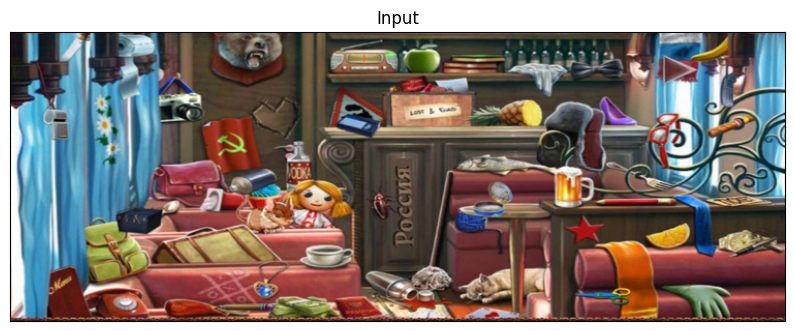

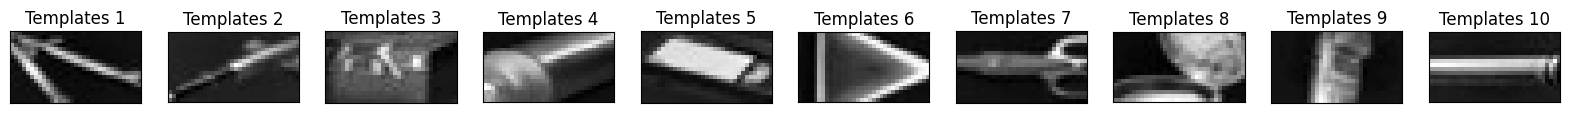

In [19]:
# inputs
hidden_rgb  = cv.imread('../data/hidden.jpeg')

# get list of templates
templates = extract_big_home_templates(hidden_rgb)
hidden_rgb = hidden_rgb[80:360]
hidden_gray = cv2.cvtColor(hidden_rgb, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1,1, figsize=(10, 10),squeeze=False)

display_image(hidden_rgb, axes=ax[0][0])
ax[0][0].set_title("Input")
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

plt.show()

fig, ax = plt.subplots(1,10, figsize=(20, 20),squeeze=False)

for i, template in enumerate(templates):
    display_image(template, axes=ax[0][i])
    ax[0][i].set_title("Templates {:d}".format(i+1))
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])


**QUESTION** (/10)

Your task is to use these templates and what you have learned so far to find the hidden objects in the given illustration `hidden_gray`.

Plot the image `hidden_rgb` showing the location of each object and report the number of miss. Note each object is present once in the scene. So you can write a variant of `multiMinMax()` (e.g `minMax()`) which returns the global minimum or maximum of a 2D `src` image according to the provided `flag` (`flag = "min"` or `flag = "max"`). You can reuse the function `cv.minMaxLoc()`.


In this exercise, you may choose to use any transformation in the input image or tweak the distance metric. You can't modify the templates (only scale it).

Follow the code below and provide some insights like:

* What metric seemed to work better this time ? 
* Was it different from the previous exercise ?
* How many objects did you find ? Why these ones in partiular ?

Save the output in a separate image for easier visualization.

In [41]:
def minMax(src, flag):
    
    #YOUR CODE HERE
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(src)

    if flag == 'min' :
        # location = np.unravel_index(np.argmin(src), src.shape)
        return min_loc
    if flag == 'max' :
        # location =  np.unravel_index(np.argmax(src), src.shape)
        return max_loc

    # return location

# Function to create a single ROI
def drawROI(src, template, location, color = (255,255,255)):
    h,w = template.shape[:2]
    # Make copy of image to draw on it without changing the original image
    canvas = src.copy()
    
    cv.rectangle(canvas, location, (location[0] + w, location[1] + h), color, 2)
    
    return canvas

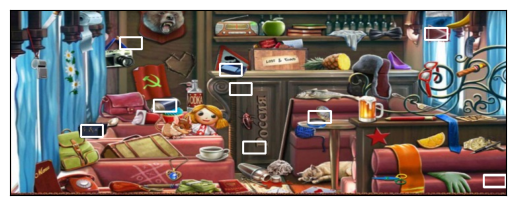

In [21]:
#YOUR CODE HERE
# Résultats éclatés

src_holder_hidden = hidden_rgb.copy()

for i,template in enumerate(templates) :

    distance_map = cv.matchTemplate(hidden_gray,template,cv.TM_SQDIFF_NORMED)
    location = minMax(distance_map,'min')
    # Draw the ROIs 
    src_holder_hidden = drawROI(src_holder_hidden,template, location)

# example:
display_image(src_holder_hidden)

**YOUR ANSWER**

- No metric showed particularly satisfactory results.
- /
- Templates 3,4,6 and 8 were found, as they all seem to have very distinct shapes (proeminent edges), as the other templates are not as defined.

#### 4) Find all hidden objects

As you can see, using template matching can be tricky, even when you have _good_ templates. As for the last exercise, you will try to design good __templates__  in order to find all hidden objects in the image. In this exercise, you can (if you want) use the information of the 3 RGB channels (to generate a 1 _better_ 1 channel image for example) and transform the input image (for example to homogenize the scale!). You can reuse any features from the last chapter to improve the matching.

**QUESTION** (/6)

Plot your selected templates and the input image _showing_ the location of each object (if you can) and any miss if any.

Follow the code below and provide some insights like:

* Was it different from the previous exercise?
* What did you improve ?

In [23]:
def extract_big_home_templates_rgb(image):
    
    # We extract list of objects in a heuristic manner
    list_image = image[370:418, 77:712].copy()
    
    # There are 10 objects per image
    n_objects = 10
    stride = list_image.shape[1]/10
    
    # Extract each template image
    objects = []
    for i in range(n_objects):
        object_rgb = list_image[:,int(stride*i):int(stride*(i+1))][15:-15,15:-15]
        center_coordinates = (int(object_rgb.shape[1]/2), int(object_rgb.shape[0]/2))
        object_rgb = cv2.ellipse(object_rgb, center_coordinates, (40, 32), 0, 0, 360, (35, 35,35), 20)
        objects.append(object_rgb)
        
    return objects

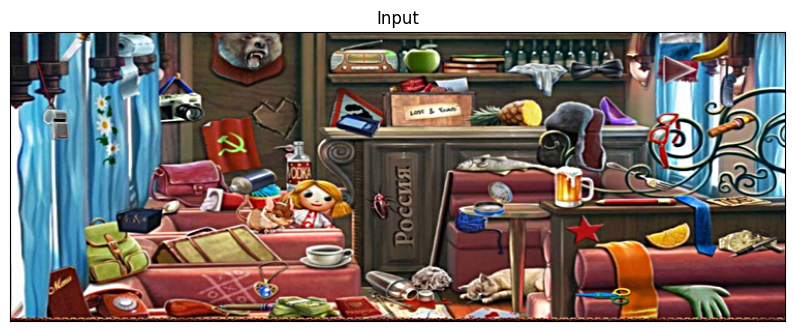

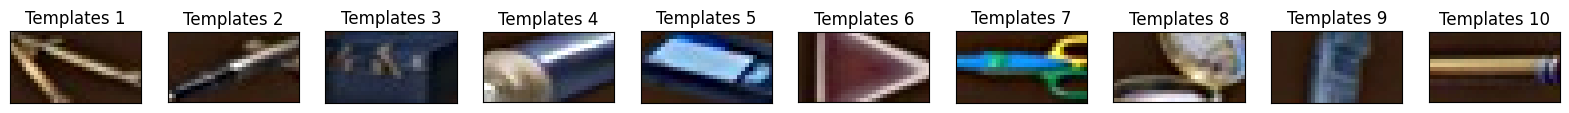

In [47]:
# inputs
hidden_rgb  = cv.imread('../data/hidden.jpeg')

blurred = cv.GaussianBlur(hidden_rgb, (9,9), 10.0)
hidden_rgb = cv.addWeighted(hidden_rgb, 1.5, blurred, -0.5, 0)

# get list of templates
templates = extract_big_home_templates_rgb(hidden_rgb)
hidden_rgb = hidden_rgb[80:360]
hidden_gray = cv2.cvtColor(hidden_rgb, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1,1, figsize=(10, 10),squeeze=False)

display_image(hidden_rgb, axes=ax[0][0])
ax[0][0].set_title("Input")
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

plt.show()

fig, ax = plt.subplots(1,10, figsize=(20, 20),squeeze=False)

#######################

# YOUR CODE HERE TO LOAD YOUR TEMPLATES

for i, template in enumerate(templates):
    display_image(template, axes=ax[0][i])
    ax[0][i].set_title("Templates {:d}".format(i+1))
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
#######################


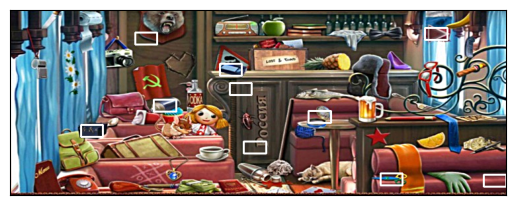

In [48]:
src_holder_hidden = hidden_rgb.copy()

for i,template in enumerate(templates) :

    distance_map = cv.matchTemplate(hidden_rgb,template,cv.TM_SQDIFF_NORMED)
    location = minMax(distance_map,'min')
    # Draw the ROIs 
    src_holder_hidden = drawROI(src_holder_hidden,template, location)

# example:
display_image(src_holder_hidden)

**YOUR ANSWER**

The detection is clearly improved from the previous one. Obvious objects as for instance the cissors are correctly detected. Compared to the previous question, two differences are implemented:
- Use of the color image: Now as we use a colored version of the image, the match template can use more informations and therefore the result is improved.
- Sharp edges: in order to improve the result, the edges and reinforces. This is achieved by subtracting a gaussian blured version of the image to the orignal one.

## 2.2 Person Detection
(*25 points*)

In this section, we will return to the HOG features from the last Chapter. As we said before, HOG was proposed as a useful feature for human detection. If you reach this point, you may have noticed that Template matching may not be the best option for this. Imagine how difficult it would be to create a template for any human-shaped structure that you would like to detect as a human in a scene. Instead of that, you will train a Linear Classifier from scratch.

In this section, you will use OpenCV's implementation to extract the HOG's features of the INRIA's Persons dataset to train an SVM Linear classifier (https://en.wikipedia.org/wiki/Support_vector_machine). For this, we will train the SVM classifier using the Scikit-learn Machine Learning library (http://scikit-learn.org).

### 2.2.1 Dataset 

 This dataset was collected as part of the research work on detection of upright people in images and video. The research is described in detail in the CVPR 2005 paper _Histograms of Oriented Gradients for Human Detection_. The full dataset is about ~1 GB and contains several thousands of pedestrian images. 
 
For your convenience, the dataset is already separated into two sets: 
* "**_Positives_**" which are all the images containing at least one person. 
* "**_Negatives_**" any kind of non-human shaped objects images.

In addition, the data is already separated in a **training** and **testing** set.


You can download the dataset on Moodle and put the `.tar` file into the `data` folder. To uncompress the data, you can either use the function below or directly do it in your file explorer, it is up to you.

In [49]:
def maybe_extract(filename, force=False):
    """
    Uncompress a given *.tar file
    :param filename: File to be uncompressed
    """
    # remove .tar.gz
    root = os.path.splitext(os.path.splitext(filename)[0])[0] 
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s dataset (seems to be) already present.\nSkipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        tar.extractall(os.path.dirname(filename))
        tar.close()
    print("All setup.")

In [50]:
# Optional
maybe_extract(filename='../data/INRIAPerson.tar')

Extracting data for ../data/INRIAPerson. This may take a while. Please wait.
All setup.


### 2.2.2 Features Extraction

Once you have the data, you will now process each image using the OpenCV HOGDescriptor implementation [[doc](https://docs.opencv.org/4.0.0/d5/d33/structcv_1_1HOGDescriptor.html)]. 

In the next cell, we define the parameters of the HoG descriptor and load the path to the images with the function `return_img_path()`.




In [51]:
def return_img_path(sample_file, folder):
    with open(sample_file, 'rt') as f:
        img_path = []
        for im_path in f:
            if im_path.strip():
                path = os.path.join(folder, im_path.strip())
                img_path.append(path)
    return img_path
    

# Data location
#Positive folder:
pos_im_path = "../data/inria_train_pos.txt"
#Negative folder:
neg_im_path = "../data/inria_train_neg.txt"
    

path_img_pos = return_img_path(pos_im_path, folder='../data/INRIAPerson')   
path_img_neg = return_img_path(neg_im_path, folder='../data/INRIAPerson')   


# Image descriptor parameters
# ---------------------------
# Window size: this specifies the size of the input image (remember to scale the input to this size!)
win_size     = (64,128)
# Size on pixels of each block (remember that a block contains a set of CELLS)
block_size   = (16,16)
# The separation between each block. If this value is less than the block size, 
# there will be overlapping blocks. 
block_stride = (8,8)
# The size of each CELL. Each cell computes one histogram. The cells should FIT inside a block.
cell_size = (4,4)
# Number of bins for each histogram.
nbins = 10


**QUESTIONS (/3)** 

In the next cell, implement the function `_extract_feature()` that takes as input a list of path to images, the HoG descriptor, the label of the images and the input size of the HoG descriptor. The function returns a list of HoG features for each image and a list of corresponding label. 

**WARNING**: The dataset may contain corrupted images. Be sure, inside your code, to check if the image was loaded properly. Otherwise, you will get either trash features or execution errors.


Sometimes OpenCV can not load the image properly, that's why we're gonna use another package to load them. The command below shows how to achieve the same as `cv2.imread(...)` function.

```python
np.flip(np.asarray(imageio.imread('<image_path>', dtype=np.uint8))[..., :3], -1)
```

The `imread(...)` function load the image, it is then converted to numpy array with `np.asarray()`. Only the first 3 channels are selected with `[..., :3]` and finally it is converted from `RGB` to `BGR` with the `np.flip(..., -1)` function. 

In [78]:
import imageio.v3 as iio
def _extract_feature(img_path, descriptor, label, hog_size):
    
    features = []
    labels = []
    
    ## YOUR CODE HERE
    for path in img_path:
        img = np.flip(np.asarray(iio.imread(path))[..., :3].astype(np.uint8), -1)
        img = cv.resize(img, hog_size)
        feature = descriptor.compute(img)
        features.append(feature)
        labels.append(label)
    
    return features, labels

The next cell loads the HoG features and labels for the positive and negatives images of the training set.

**QUESTIONS (/2)**
- The length of each individual feature vector should be of 16800. Why?
- What should be the size of the _training_features_ list? Why?


In [79]:

# hog is an instance taht contains the info and is able to compute the feature vector.
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)


# lists to save the features and labels.
training_features = []
labels = []

# Positive features
print ("Calculating the descriptors for the positive samples and saving them")
pos_feat, pos_label = _extract_feature(path_img_pos, descriptor=hog, label=1, hog_size=win_size)   
training_features.extend(pos_feat)
labels.extend(pos_label)

#Negative features
print ("Calculating the descriptors for the negative samples and saving them")
neg_feat, neg_label = _extract_feature(path_img_neg, descriptor=hog, label=0, hog_size=win_size)   
training_features.extend(neg_feat)
labels.extend(neg_label)

# Summary
print('#Samples: {}'.format(len(training_features)))
print('Feature size: {}'.format(training_features[0].shape))


Calculating the descriptors for the positive samples and saving them
Calculating the descriptors for the negative samples and saving them
#Samples: 3634
Feature size: (16800,)


**YOUR ANSWER**
images are reshaped with hog_size. In this case, the shape of the image will be 64x128. After applying the cell transformation, the image has now size 16x32. 

### 2.2.3 Classifier

Now that you have the HoG features, you'll train a Linear Support Vector Classifier [[doc](
http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)] using Scikit-learn. 

Please take the time to read the implementation details, but more importantly, the examples and theory provided in the documentation. 

**QUESTION (/5)** 

In the next cell, train a SVM classifier on the HoG features.

In [64]:
# Stack features
train_features = np.asarray(training_features)
train_labels = np.asarray(labels)

# Train classifier
# Check the dimentions first
print('Feature matris dims: {}, labels dims: {}'.format(train_features.shape, 
                                                        train_labels.shape))

#########################
## YOUR CODE HERE
# create a LINEAR classifier instance here (LinearSVC): 
X, y = train_features, train_labels
clf = LinearSVC(dual=True, random_state=0)

# Train the classifier (LinearSVC.fit).
print ("Training a Linear SVM Classifier")
clf.fit(X, y)

print('Done')


#########################

Feature matris dims: (3634, 16800), labels dims: (3634,)
Training a Linear SVM Classifier
Done


### 2.2.4 Evaluation

After training the classifier, you can use this Support Vector Machine to *classify* if an *HOG feature vector* (with strictly the same dimensions as your training data) comes from an image with a human-shaped form in it (prediction = 1), or not (prediction = 1).


**QUESTIONS (/10)**
In the next cell, for each image in the test folders: 
* Compute the HOG feature vector,
* Predict/classify the vector as positive (1) or negative (0),
* Compute the estimation error for the negative and positive images _separetely_,
* Compute and report the F1-score [[doc](https://en.wikipedia.org/wiki/F1_score)]

In [ ]:
test_neg_path = "../data/inria_test_neg.txt"
test_pos_path = "../data/inria_test_pos.txt"

###################
# YOUR CODE HERE 

from sklearn.metrics import f1_score

test_path_img_pos = return_img_path(test_pos_path, folder='../data/INRIAPerson')   
test_path_img_neg = return_img_path(test_neg_path, folder='../data/INRIAPerson') 


print ("Estimating the test data [Negative samples]")
# Extract features
neg_feat, neg_label = _extract_feature(test_path_img_neg, descriptor=hog, label=0, hog_size=win_size)   
# Predict labels
neg_pred = clf.predict(neg_feat) 
# Prediction Error
err_neg = np.mean(neg_pred != neg_label)

print(f"Negative error: {err_neg*100:.2f}%")

print ("Estimating the test data [Positive samples]")
# Extract features
pos_feat, pos_label = _extract_feature(test_path_img_pos, descriptor=hog, label=1, hog_size=win_size)
# Predict labels 
pos_pred = clf.predict(pos_feat)
# Prediction Error
err_pos = np.mean(pos_pred != pos_label)

print(f"Positive error: {err_pos*100:.2f}%")
###################

test_pred = np.concatenate([neg_pred, pos_pred])
test_labels = np.concatenate([neg_label, pos_label])

f1 = f1_score(test_labels, test_pred)
err = np.mean(test_labels != test_pred)

print(f"F1 Score: {f1*100:.2f}%")

# Compute score
print('Estimation Error: {:.3f}%'.format(err * 100.0))
print('Success Rate: {:.3f}%'.format((1 - err) * 100.0))

Estimating the test data [Negative samples]
Negative error: 1.99%
Estimating the test data [Positive samples]
Positive error: 11.10%
F1 Score: 93.73%
Estimation Error: 8.486%
Success Rate: 91.514%


The basic classifier above can (should) achieve a success rate of 89% for the positive and less than 2% error for the negative images respectively. 

**QUESTION** (/5)
Can you tweak the HOG parameters to improve a little bit?

In [ ]:
## YOUR CODE HERE


Finally, from the description above, what we created is no more than a *classifier* for only 2 classes (binary classifier): human(human-shaped) or not. In order to create a functional Person detector for arbitrary images or video sequences, some engineering techniques (heuristics) need to be implemented. 

Pretty much as in template matching, in order to find a person in an arbitrary image you will need to: 

* Slide your classifier over the full area of the image.
* Detect possible matchings. 
* Report them as positive or negatives
* And optionally, repeat the procedure above in different scales, to assure multiscale detection!.

The procedure is nicely depicted in the image below for face detection.

<img src="https://www.pyimagesearch.com/wp-content/uploads/2015/03/sliding-window-animated-adrian.gif"> 
</img>
_Image taken from: https://www.pyimagesearch.com_

For now, we will leave those implementation details for later.

## 2.3 Face Recognition
(*35 points*)

In this section you will implement a face regognition algorithm using two approaches: `Eigen Faces` and `Fisher Faces` . These methods are both based dimensional reduction technics listed below:

- Principal Component Analysis ([*PCA*](http://www.utdallas.edu/~herve/abdi-awPCA2010.pdf))
- Linear Discriminant Analysis (*LDA*)

In general, in order to train a recognizer, several steps are needed and can be grouped as follow:

- Data preparation
- Recognizer training
- System validation

During validation, the system is tested with **unseen** data, i.e. the data hadn't used during the training phase, which ensures a fair performance assessment without biais. However this does not garantie that the system will *generalize* well to other dataset.

### 2.3. 1 Data Preparation

Data preparation covers various aspect of pre-processing step for training a system. At first, the images need to be splitted into two disctinct subsets thant will be used for `training` and `testing`. In our experiment the dataset used is the *Yale dataset version B*, it includes a total of 38 different identity (*i.e. subject*) each having 20 images undergoing different illumination condition for a total of 760 samples. We split the data into `training` and `testing` sets by selecting randomly samples from each subjects and placed into the corresponding subset. Special care needs to be taken in order to avoid having the same example multiple time.

The first task is to gather the labels and the images that will be used to train the system. One solution is to store these information into a dictionary where the identity is the key and the pathes to the images for this subject are the values. 

**QUESTION** (/2)

In the next cell, implement the function `load_dataset()` that takes as input the path to the dataset, and returns a dictionary in which the keys are the person ID and the values are the pathes to the corresponding images.

In [ ]:
def load_dataset(path):
    """
    Scan for images in a given `path` and extract the label as well

    :param path:    Path where YaleB dataset is stored
    :return:        Dictionary storing the ID and a list of images for this ID
    """
    data = {}
    
    # YOUR CODE HERE
        
    return data

The next cell load the data.

In [ ]:
# Load data
data = load_dataset(os.path.join('..', 'data', 'yaleB'))
assert(len(data) == 38)

When all the images and labels have been gathered, the next step is to split into two subsets, the train set and test set. The training set will be composed of $75\%$ of the images of each subject and the remaining $25\%$ will be used as test set.

Once again the two subsets information will be stored into two separates disctionary similar to what has been done earlier.


**QUESTION** (/3)

In the next cell, implement to the function `split_dataset()` that takes as input the dictionary of data and the ratio between training and testing sets, and returns two dictionaries, one with the training data and one with the testing data.

In [ ]:
def split_dataset(data, ratio):
    """
    Splipt randomly a dataset into two subset. The ratio provide the distribution for each subset

    :param data:    Overall dataset
    :param ratio:   Split ratio
    :return:        Two dictionaries, train/test
    """
    train = {}
    test = {}
    
    # YOUR CODE HERE
    
    return train, test

The next cell splits the data.

In [ ]:
train, test = split_dataset(data, 0.75)
assert(len(train) == 38)
assert(len(test) == 38)

Now with these two subsets we can load the images and extract features from them. In this case the pixel intensity of grayscale images will be used as feature, therefore for an image $I \in \mathbb{R}^{ w \times h}$ the feature vector will have a size of $wh$. This value can be quite large very easily, therefore all images will be downsampled by a factor of $2$.

All the training samples will be concatenated into a single matrix where each row is an image (*i.e. flattened*) with dimensions $N \times K$ where $N$ is the number of samples and $K$ is the dimension of a single image, $K = \frac{wh}{4}$. Also, make sure the features are float32 normalized between 0 and 1. 

The corresponding labels will also be concatenated into a single vector of dimension $N \times 1$.


**QUESTION** (/5)

In the next cell, implementto the function `load_images()` that takes as input a dictionary of data, and returns the feature matrix and the label vector. 

In [ ]:
def load_images(subset):
    """
    Load images into one single matrix where each row is one single image (flattened). The final dimensions is [N x K]
    where N is the numper of samples available and K is the number of pixel in one image. The original image is first
    downspample by a factor of 2

    Labels are also exported into a single vector of dimensions [N x 1]

    :param subset: Dictionary storing labels/images
    :return:       Data matrix and label vector
    """
    
    data = None
    label = None
    
    # YOUR CODE HERE
    
    return data, label

The next cell loads the training data and the labels. 

In [ ]:
# Load training images into memery
train_img, train_label = load_images(train)
# Sanity check
assert(train_img.shape[0] == train_label.size)
# Output number of samples
print("There is a total of {} samples for the training set".format(train_label.size))


### 2.3.2 Eigenfaces

To perform recognition, all pixel's intensities are used as feature vector. The dimension of theses descriptors will be large, therefore a *clever* representation of the data, called subspace, is needed. 

This subspace is computed using *Principal Component Analysis* method in order to extract meaningfull information and reduce the dimension of the problem. The *PCA* approach is completely unsupervised and extract the directions, or *basis*, where the variation in the data are the largest inside the feature space. 

Since we are interested in the variation in the data, the first step is to remove the commmon information present in all samples by subtracting the **average face**. The average is computed using all training samples $I_i$ as follow:

$$
\bar{\boldsymbol{I}} = \frac{1}{N_t} \sum_{i=0}^{N_t} \boldsymbol{I}_i
$$

where $N_t$ is the total number of training samples and $I_i$ is a specific training sample. Then each samples $I_i$ are normalized as follow:

$$
\boldsymbol{\phi_i} = \boldsymbol{I}_i - \bar{\boldsymbol{I}}
$$

With all samples normalized, we need to find a set of orthognonal basis which best explain the distribution of our data. To do so we compute the eigendecomposition of the covariance matrix of the normalized samples.

$$
\boldsymbol{C} = \frac{1}{N_t - 1} \sum_{i}^{N_t} \boldsymbol{\phi}_i\boldsymbol{\phi}_i^{\top} = \frac{1}{N_t - 1} \boldsymbol{\Phi\Phi}^{\top}, \quad \text{where } \Phi = \left[\boldsymbol{\phi}_0, \dots, \boldsymbol{\phi}_{N} \right]
$$

Find the eigenvectors $u_k$ and the eigenvalues $\lambda_k$. 

So far the dimensions of the problem have not been reduced. Moreover the size of the covariance matrix will be $K \times K$ with $K = \frac{wh}{4}$. Therefore we will find $K$ eigenvectors representing the variation in our data. To reduce the dimension we will select only the eigenvectors that contribute the most to the variation and dropping the one with little influence. Doing so will reduce the dimension of the subspace to $K \times K_m$.

The question is how to properly determine this $K_m$ value. It can be done by using the eigenvalues computed earlier. These values are representing the energy each vector contribute for. Therefore it is possible to dertmine the number of basis to select in order to retain a certain amount of energy.

$$
\frac{\sum_{k=0}^{K_m}\lambda_k}{\sum_{i=0}^{K}\lambda_i} < \Theta
$$

Where $\Theta$ represents the amount of energy to retain, which usually is around $95\%$ but can vary depending on the application. 
Finally the subspace is defined as:

$$
\boldsymbol{U} = \left[\boldsymbol{u}_0, \dots, \boldsymbol{u}_{K_m}\right], \quad \boldsymbol{U} \in \mathbb{R}^{K \times K_m}
$$

In practice, the PCA decomposition is computed using `sklearn.decomposition.PCA`, more information can be found [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).


**QUESTION** (/3)

In the next cell, compute the face subspace on the training data by retaining $95\%$ of the variance present in the training data.

Once the subspace is computed, display the first $8$ modes or *eigenfaces*. 
Comment on what you see. What do you thing are the limitations of such approach ?


In [ ]:
# YOUR CODE HERE



**YOUR ANSWER**

In classification problem, it is always interesting to visualize the feature subspace to evaluate if they discriminate properly the different subjects. Having proper plots of an $N$ dimensional space is not feasable, and, therefore, we use only a few components (*i.e. 2 or 3*) of our projected samples. 


We want a subspace that is able to separate and cluster properly each subject to avoid miss recognition. The code snippet below shows the $3^{rd}$ and $4^{th}$ components on a $2D$ plane.

**QUESTION** (/2)

Do we have clean inter-subject separation ? Comment the results.


In [ ]:
# Poject data onto subspace
proj_train = pca.transform(train_img)

# Visualize 
# Colors for distinct individuals
colors = LabelEncoder().fit_transform(train_label.ravel())

plt.figure(figsize=(12, 7))
plt.scatter(proj_train[:, 2], proj_train[:, 3], c=colors)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('Trainset clusters')

**YOUR ANSWER**

In this new subspace, each training sample has a representation, given by its projection into the eigen subspace (*i.e. eigenface*) as follow:

$$
\boldsymbol{\omega}_i = \boldsymbol{U}^\top \boldsymbol{\phi}_i
$$

In the training set, there are multiple samples avaible for each subject. Their projection won't be exactly the same, and, therefore, we need a more generic representation of each person. One option is to average all representation of the specific person:

$$
\boldsymbol{\Omega}_k = \frac{1}{N_k} \sum_{p} \boldsymbol{\omega}_p
$$

where $N_k$ is the number of samples for subject $k$ and $\boldsymbol{\omega}_p$ represents the projected samples of subject $k$. In our case, $k$ goes from $0$ to $37$.

**QUESTION** (/3) 

In the next cell, implement the function `compute_centroids()` that takes as input the feature matrix, the transformation to be applied to the feature matrix and the corresponding label, and returns each subject's centroid, and the corresponding labels.




In [ ]:
def compute_centroids(data, trsfrm, label):
    """
    Given a list of training samples, compute the centroids of each uniques labels

    :param data:    Matrix with all feature vectors stored as row
    :param trsfrm:  Embeddings to use (object with `transform(X)` method available such as PCA/LDA from sklearn)
    :param label:   List of corresponding labels
    :return:        Centroids, unique labels
    """

    centroids = None
    unique_lbl = None

    # YOUR CODE HERE
    
    return centroids, unique_lbl

The next cell calculates the centroid of each subsject. 

**QUESTION** (/1)

What is the number of centroid? Why?

In [ ]:
# Define centroids
train_centroids, train_centroid_label = compute_centroids(train_img, pca, train_label)


So far we've learned a face representation and computed the descriptors for the training samples. Ultimately, we want to use them to recognize face. The first step is to bring the *new* sample into our face *subspace*, similarly to the training samples:

$$
\boldsymbol{\omega}_n = \boldsymbol{U}^{\top}(\boldsymbol{I}_n - \bar{\boldsymbol{I}})
$$

where $U$ is the face subspace, $\bar{\boldsymbol{I}}$ is the average face learned on the training data, and $\boldsymbol{I}_n$ is the new sample to recognize.

In this subspace, we can measure the **similarity** (*distance*) between a testing sample and the centroids $\boldsymbol{\Omega}_k$ computed before. The predicted label will be the one corresponding the the closest centroid. 

$$ 
min \left|\left| \boldsymbol{\omega}_n - \boldsymbol{\Omega}_k \right|\right| \quad \forall k \in \{Train\}
$$


**QUESTION** (/2)

In the next cell, implement the function `recognize` that takes as input the transformation, the centroids, the centroid labels and the new samples, and returns the predicted labels of the new samples.


In [ ]:
def recognize(trsfrm, centroids, centroids_label, samples):
    """
    Perform object recognition on a given list of ``amples

    :param trsfrm:          Embeddings to use (object with `transform(X)` method available such as PCA/LDA from sklearn)
    :param centroids:       List of centroids learned in training phase
    :param centroids_label: Label corresponding to the centroids
    :param samples:         List of samples to recognize
    :return:                Predicted labels
    """

    pred = None 
    
    # YOUR CODE HERE
    
    return pred

The next cell validates the implementation with the whole system on the training set. The expected recognition accuracy should by close to 100% depending on the task difficulty.

In [ ]:
# Recognize training set
pca_train_pred = recognize(pca, train_centroids, train_centroid_label, train_img)

# Compute performance
n_err = np.count_nonzero(np.where(pca_train_pred != train_label))
train_acc = 1.0 - n_err / train_label.size
print("The recognition accuracy on the trainig set is {:.2f}".format(train_acc))


**QUESTIONS** (/2)

In the nex cell, estimate the recognition accuracy on the testing set. Comment the results.


In [ ]:
test_acc = 0

# YOUR CODE HERE


print("The recognition accuracy on the testing set is {:.2f}".format(test_acc))

**YOUR ANSWER**

Measuring accuracy of the system is a good indicator of the overall performance but does not indicate where the system is performing poorly. This can be quantified using **Confusion Matrix**. It describes the performance of classification model and shows how the system is confused for each samples in the training set.

Such representation can be computed using `sklearn.metrics.confusion_matrix`, details are provided [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

**QUESTION** (/2)

In the next cell, calculate and visualize the confusion matrix using the function `plot_confusion_matrix()` of the `utils.py` file. Comment the results.

In [ ]:
#########################
# YOUR CODE HERE
#########################

# Plot confusion matrix
plt.figure(figsize=(12, 7))
plot_confusion_matrix(cm, classes, normalize=True)


**YOUR ANSWER**

### 2.3.3 Fisherface

The subspace computed before with *PCA* was looking at directions where the variation in the data is maximum without paying attention to the class each data point belongs to. Therefore this approach is unsupervised. The major drawback is that the class separability is not garantee to be optimum. 

The approach of *Linear Discriminant Analysis* is to find a subspace where the variation is large (*i.e. similar to PCA*) but also to maximize the inter-class separability by taking into account each sample's label. The figure below shows an example:

<img src="../data/lda_example.png" alt="Drawing" style="width: 400px;"/>

Such subspace can be computed as follow:

- Compute the scatter matrices (*intra-classes* / *inter-classes*)
- Compute the eigenvectors / eigenvalues
- Select the $K_m$ largest eigenvalues and their corresponding eigenvectors

Given a set of samples $\boldsymbol{I}_0, \dots, \boldsymbol{I}_N$ and their corresponding labels $y_0, \dots, y_N$, the intra-class scatter matrix is computed as follow:

$$
\boldsymbol{S}_w = \sum_{i=1}^N \left(\boldsymbol{I}_i - \boldsymbol{\mu}_{y_i}\right) \left(\boldsymbol{I}_i - \boldsymbol{\mu}_{y_i}\right)^{\top}
$$

where $\boldsymbol{\mu}_{k}$ is the sample mean of the $k^{th}$ class.
Then the inter-class scatter matrix is defined as:

$$
\boldsymbol{S}_b = \sum_{k=1}^{m} n_k (\boldsymbol{\mu}_k - \boldsymbol{\mu})(\boldsymbol{\mu}_k - \boldsymbol{\mu})^{\top}
$$

where $m$ is the number of classes, $\boldsymbol{\mu}$ is the overall sample average and $n_k$ is the number of samples in the $k^{th}$ class.

Finally the subspace $\boldsymbol{W}$ can be computed by solving the following generalizeed eigenvalue problem:

$$
\boldsymbol{S}_b \boldsymbol{W} = \lambda \boldsymbol{S}_w \boldsymbol{w}
$$

Finally at most $m-1$ generalized eigenvectors are useful to discriminate between $m$ classes.

In practice, such decomposition can be computed using `sklearn.discriminant_analysis.LinearDiscriminantAnalysis`, more information available [here](http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html).

**QUESTION** (/2)

In the next cell, compute the *LDA* subspace similar to what you have done before and display the first 8 basis (*i.e. Fisherface*).


In [ ]:
# YOUR CODE HERE


**QUESTIONS** (/2)

In the next cell, visualize the subspace created by the *LDA* decomposition, similarly to the PCA method. 

What do you see? Is it better than before ? Comment the results.


In [ ]:
# YOUR CODE HERE


**YOUR ANSWER**


**QUESTION** (/2)

In the next cell, compute the recognition accuracy on the *training*/*testing* set for the *LDA* recognizer. Comment the results.


In [ ]:
train_acc = 0
test_acc = 0

######################
# YOUR CODE HERE
######################

print("The recognition accuracy on the trainig set is {:.2f}".format(train_acc))

print("The recognition accuracy on the testing set is {:.2f}".format(test_acc))

**YOUR ANSWER**

**QUESTION** (/2)

Compute the *Confusion Matrix* and comment on the result you have


In [ ]:

######################
# YOUR CODE HERE
######################

# Plot confusion matrix
plt.figure(figsize=(12, 7))
plot_confusion_matrix(cm, classes, normalize=True)

**YOUR ANSWER**

**QUESTION** (/2) 

You have implemented / tested two approaches for face recognition which one works the best and why ? What's are the pro/cons of each method ?


**YOUR ANSWER**